In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from itertools import combinations
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction import DictVectorizer
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
import pprint

In [2]:
import at2df

In [3]:
pd.options.display.float_format = '{:.2f}'.format # This doesn't seem to do anything though...
sns.set(rc={"figure.figsize":(7, 5)})
sns.set(font_scale=1.25)

In [4]:
VERBOSE = True
SAVE = True
savedir = 'results'
kwargs_svg = {'format': 'svg', 'bbox_inches': 'tight'}
kwargs_png = {'format': 'png', 'bbox_inches': 'tight', 'dpi': 300}

# Analyze Cryptopolitics survey results

## Import data

In [5]:
at = at2df.get_airtable()

In [6]:
df = at2df.get_table_as_df(at, 'Cryptopolitical Typology Quiz')

In [7]:
# Define relevant columns lists, in order
cols_questions = ['1. Which statement comes closest to your views?', 
                  '2. Which blockchain is the best?','3', '4', '5', '6', '7', '8',
                  '9. In order to grow, the crypto ecosystem should:','10', '11', '12', '13',
                  '14. To get more favorable regulation of cryptocurrencies from national governments, the most important thing the crypto community can do is:',
                  '15', '16. Who should have decision-making power over a blockchain?', '17. I\'m here for...',
                  '18. Do you consider yourself:', '19. OPTIONAL: Do you affiliate with any of the following ecosystems or communities?']

cols_results = ['classification', 'politics', 'economics', 'governance', 'maxi']

# To convert back and forth between column names (question text) and question number
n2qDict = {i+1: x for (i, x) in enumerate(cols_questions)}
q2nDict = {x: i+1 for (i, x) in enumerate(cols_questions)}

In [8]:
# Split into questions and faction results DataFrames
df_questions = df[cols_questions]
df_results = df[cols_results]

## Data cleaning

In [9]:
# Replace old version of a response value with updated one
oldVal = "Blockchain and DeFi are predatory technologies that, on balance, will harm most members of people."
newVal = "Blockchain and DeFi are predatory technologies that, on balance, will harm most members of society."
df_questions.loc[:,'10'] = df_questions['10'].copy().replace(to_replace=oldVal, value=newVal)

/home/notchia/miniconda3/envs/metagov/lib/python3.9/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


In [10]:
# Replace old versions of faction values with updated ones
toReplace = {'Governoob': 'Noob', 'Passerby': 'NPC'}
for key, value in toReplace.items():
    for col in cols_results:
        df_results.loc[:,col] = df_results[col].copy().replace(to_replace=key, value=value)

In [11]:
# For reference, list all answers observed for each question
if VERBOSE:
    for col in cols_questions[:-1]:
        print(col)
        for answer in df_questions[col].unique():
            print("\t", answer)

1. Which statement comes closest to your views?
	 There is no one best blockchain.
	 There is one (layer 1) blockchain that is the best.
	 nan
2. Which blockchain is the best?
	 nan
	 Ethereum
	 Polkadot
	 Bitcoin
	 Solana
	 Cardano
3
	 Crypto is mainly an economic technology.
	 Crypto is mainly a political philosophy and/or lifestyle.
	 nan
4
	 My goal in crypto is to make as much money as possible.
	 My goal in crypto is to earn a living and/or build my career.
	 My goal in crypto is to create social change and/or disrupt the industry.
	 nan
	 My goal in crypto is to have fun.
5
	 Most or all cryptogovernance should be on-chain.
	 However crypto governs itself, it should also be regulated by the government.
	 Crypto does not need (human) governance; let the algorithms run as they were designed.
	 Most or all cryptogovernance should be off-chain.
	 nan
6
	 Privacy is nice, but it’s not the most important feature of blockchain and crypto.
	 nan
	 Privacy is the most important feature o

## Distribution of factions

In [12]:
def plot_pie_faction(col, df, colors=sns.color_palette("Set2")):
    """Plot pie chart for overall faction"""
    
    vals = df_results[col].value_counts()
    
    plt.figure()
    labels = [f"{k} ({v})" for k, v in vals.items()]
    fig = plt.pie(vals, labels=labels, colors=colors, wedgeprops=dict(width=0.5))
    plt.legend(bbox_to_anchor=(1.4, 1, 1, -0.1), loc='upper left')
    
    # Save
    fname = f'{savedir}/cryptopolitics_faction_{col}'
    plt.savefig(f'{fname}.svg', **kwargs_svg)
    plt.savefig(f'{fname}.png', **kwargs_png)

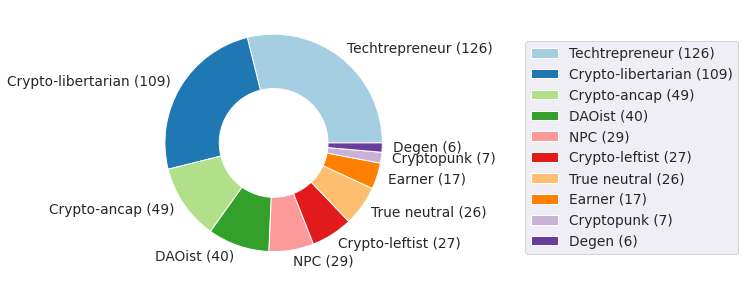

In [13]:
# Pie chart for overall faction
plot_pie_faction('classification', df_results, colors=sns.color_palette("Paired"))

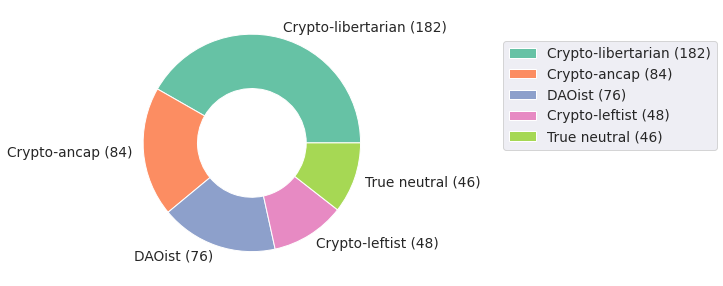

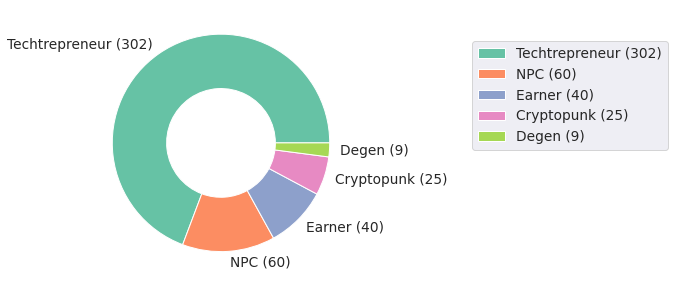

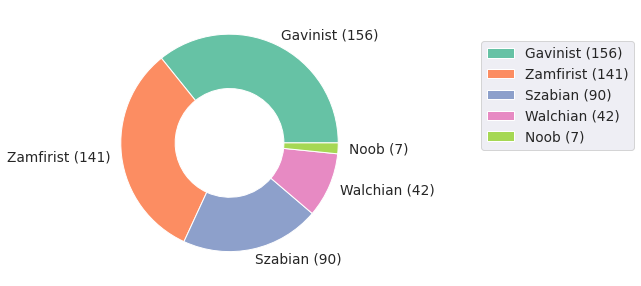

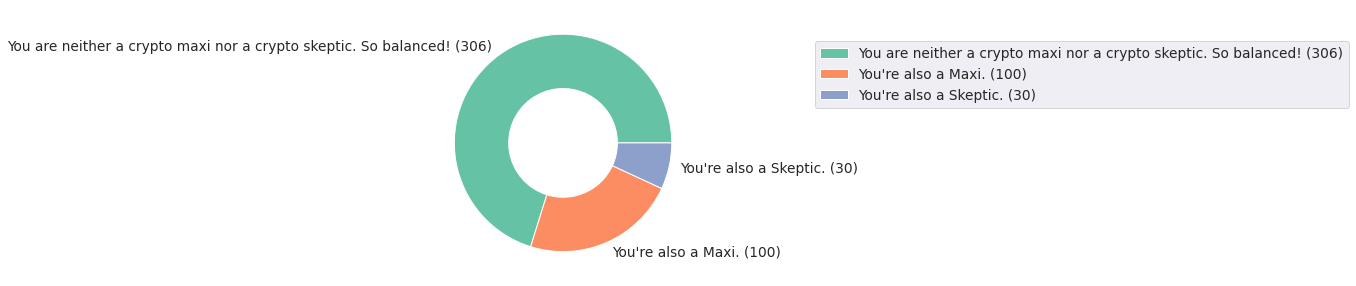

In [14]:
# Pie chart for specific dimensions
for col in cols_results[1:]:
    plot_pie_faction(col, df_results)

## Responses to questions
Reproduce the plots from the [Typeform response page](https://metagov.typeform.com/report/bz9SbjUU/ZY07qRfTs68oypzt)

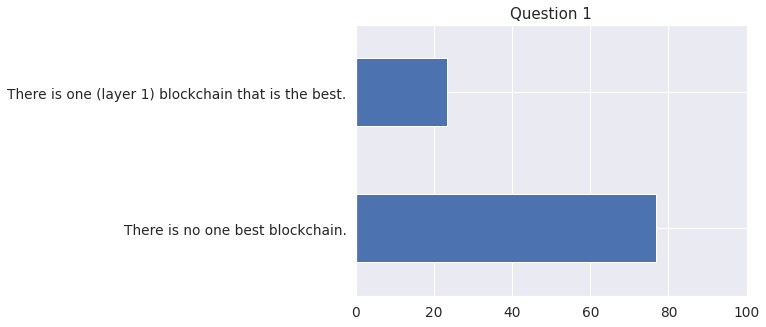

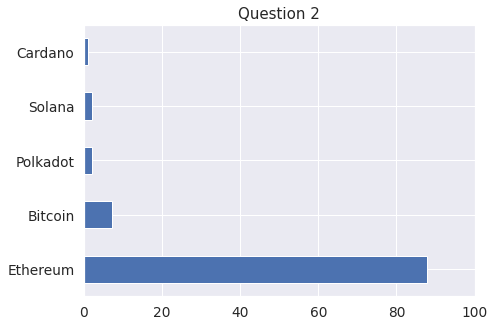

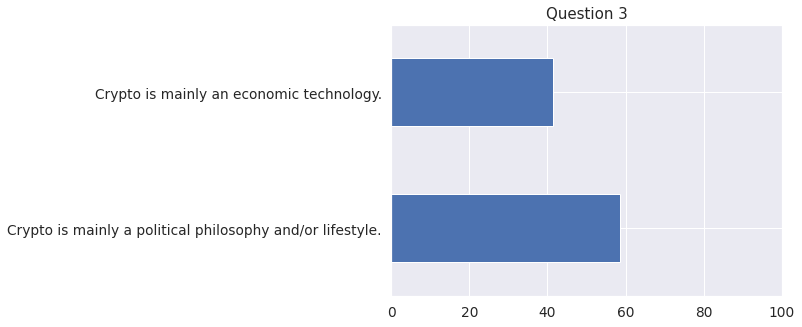

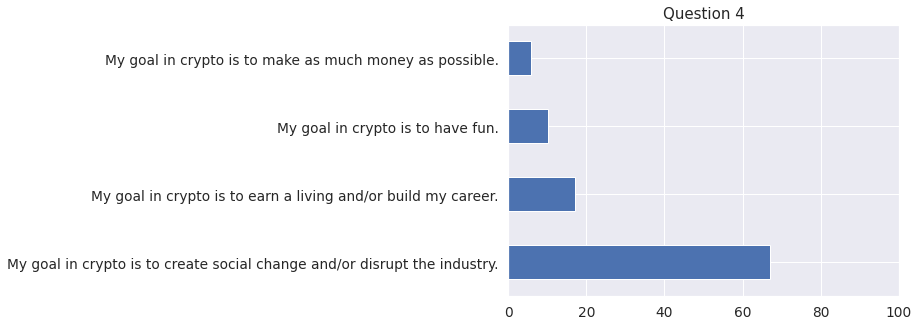

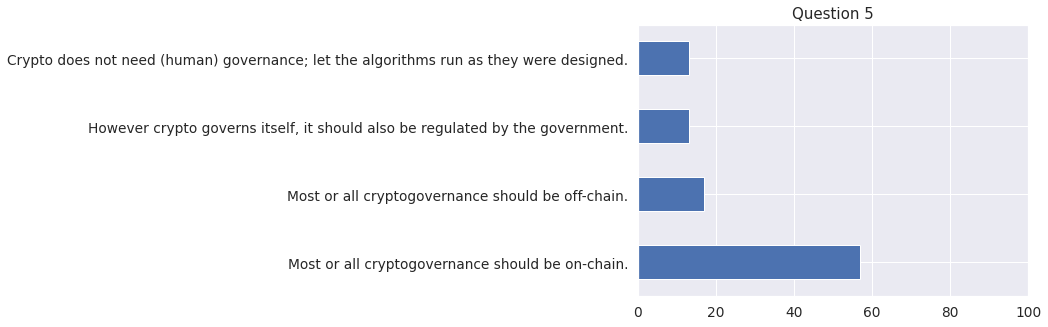

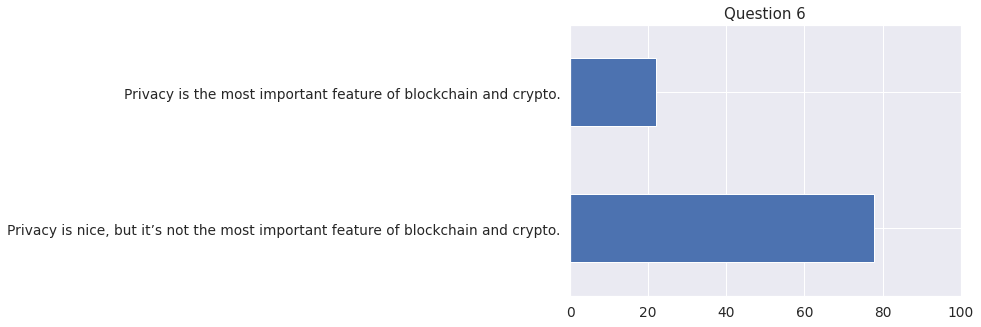

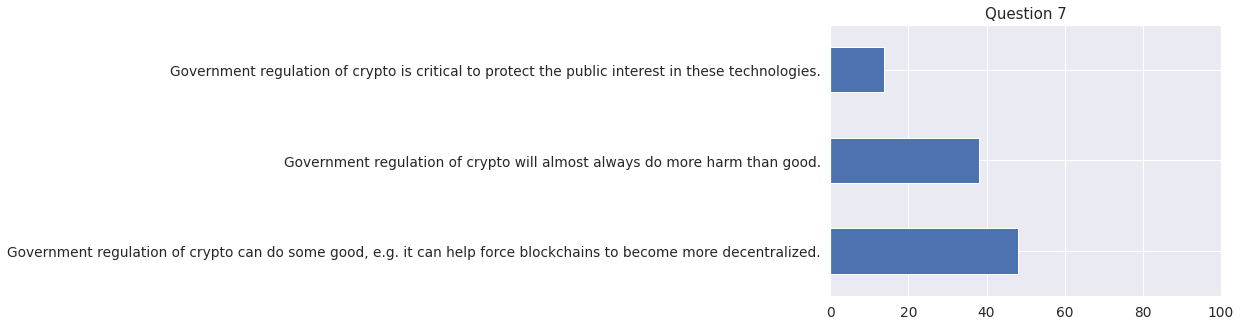

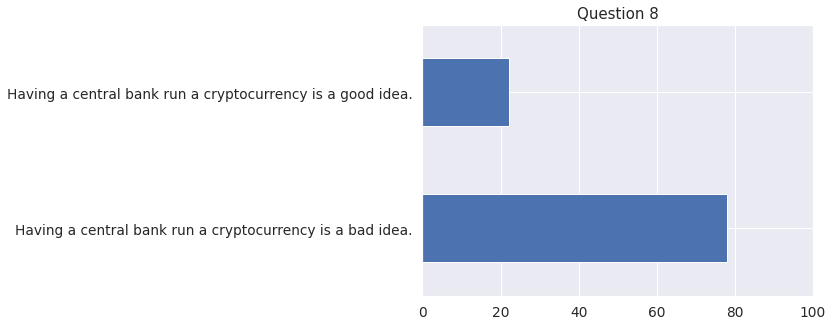

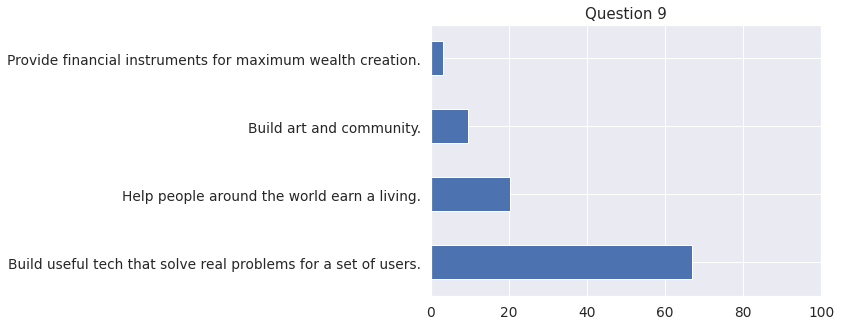

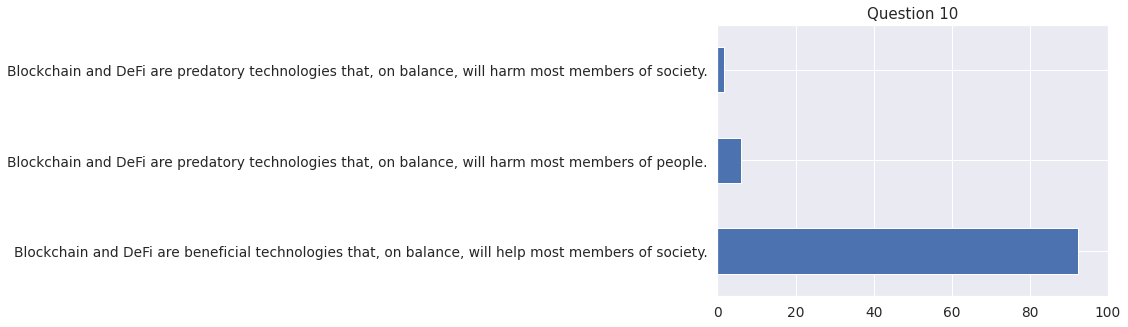

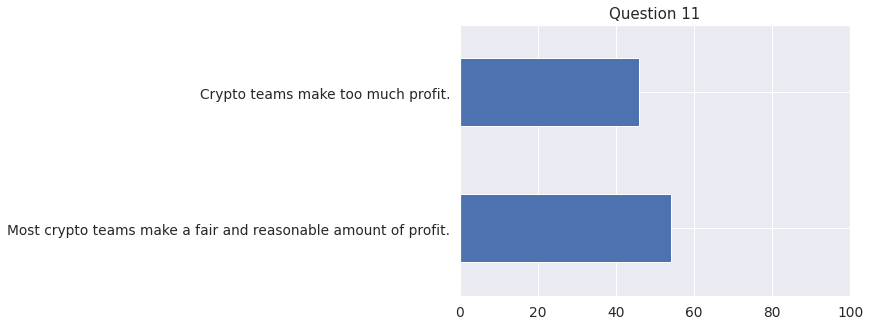

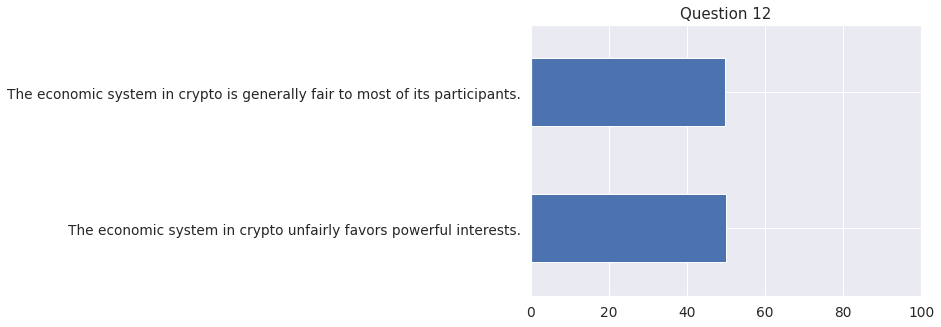

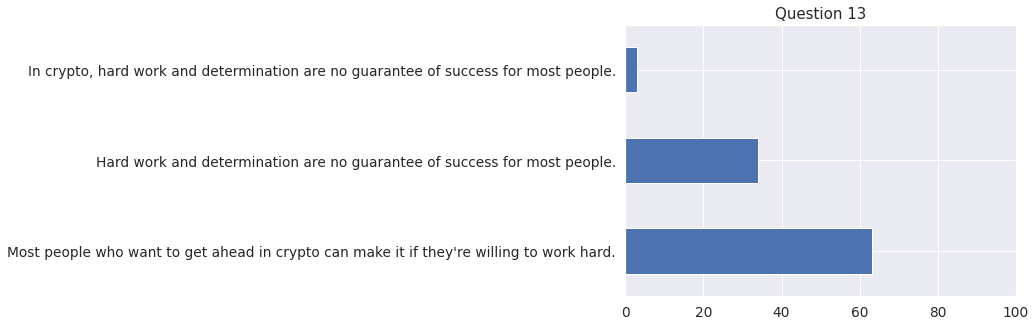

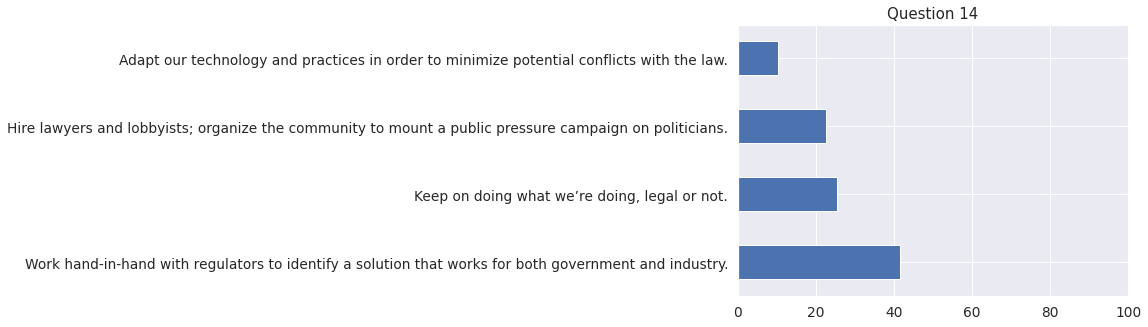

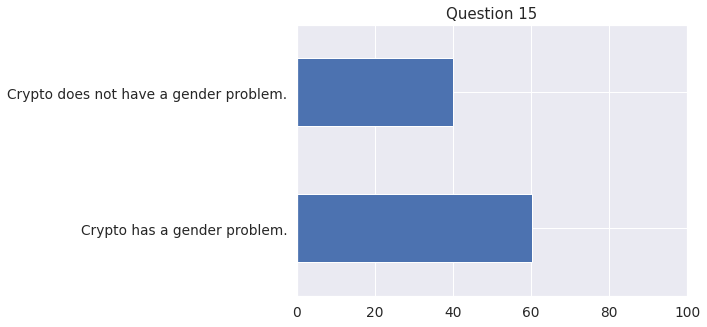

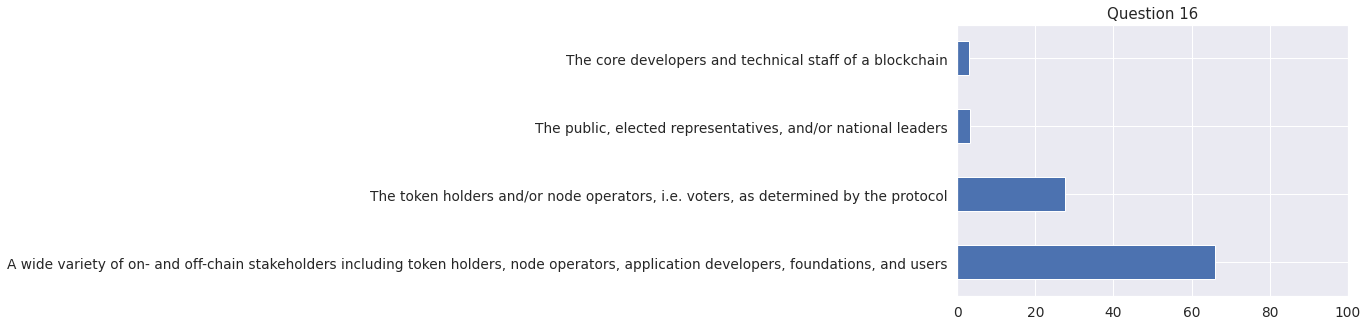

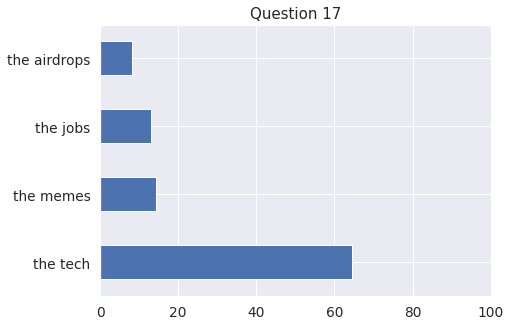

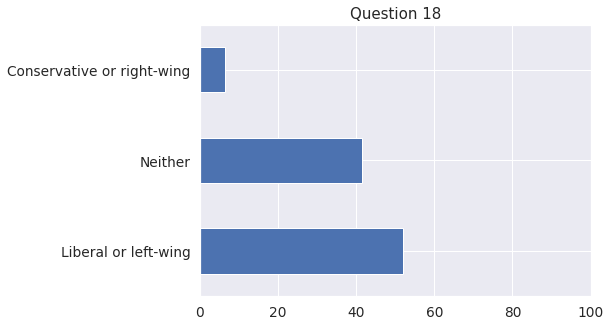

In [15]:
# Plot these differences in responses
for col in cols_questions[:-1]:
    df_tmp = df[col].value_counts(normalize=True)*100

    # Plot
    plt.figure()
    qnum = q2nDict[col]
    ax = df_tmp.plot.barh(title=f"Question {qnum}", xlim=(0,100))
    
    # Save
    fname = f'{savedir}/cryptopolitics_Q{qnum}'
    plt.savefig(f'{fname}.svg', **kwargs_svg)
    plt.savefig(f'{fname}.png', **kwargs_png)

Notes of interest on these, as of 12/20/2021:
- (Q3) A small majority of respondents consider crypto to be mainly a political philosophy/lifestyle, rather than mainly an economic technology.
    - This response was used to choose which of a respondent's political or economic faction was selected as their final classification.
- (Q5, Q16) A majority of respondents believe most or all cryptogovernance should be on-chain; however, most also believe power should be distributed over a wide variety of on- and off-chain stakeholders.
    - Slight friction between these beliefs?
- **(Q7, Q14) Mixed opinions on government regulation of crypto** - most common response is neutral; though most common response is to work hand-in-hand with regulators, a majority of respondents prefer a more neutral or adversarial approach to legal oversight.
- (Q9, Q10) Majority sentiment is that to grow, crypto should build useful tech that solves real problems for a set of users; **large majority believes blockchain and DeFi are beneficial technologies** that, on balance, will help most members of society.
- **(Q11, Q12) Respondents are polarized** on whether crypto teams make a fair and reasonable amount of profit or too much profit, and similarly, whether the economic system in crypto is generally fair to most of its participants or unfairly favors powerful interest.


## Correlation table/heat map
For all pairs of questions, cross-tabulate and calculate Cramer's V for strength of relation

In [16]:
def cramers_v(q1, q2, verbose=False, save=False):
    """Calculate Cramer's V for two categorical questions by cross-tabulating"""
    
    assert len(q1.index) == len(q2.index), "Make sure the datasets are of equal length"
    
    # Skip questions with list as response
    try:
        ct = pd.crosstab(q1, q2)
    except TypeError:
        return np.nan
    
    chi2 = stats.chi2_contingency(ct)[0]
    n = len(q1.index)
    nRows, nCols = ct.shape
    minDim = min(nRows-1, nCols-1)
    
    # Only compute if both questions have at least two observed responses
    # E.g., Q2 is only answered if a particular answer is given to Q1
    if minDim == 0:
        return np.nan
    
    V = np.sqrt((chi2/n)/minDim)
    
    ct_norm = pd.crosstab(q1, q2, normalize=True)*100
    
    if VERBOSE:
        print(ct_norm)
    if save:
        ct_norm.to_csv(f"{savedir}/cryptopolitics_{q1.name}-{q2.name}.csv")
    
    return V

In [17]:
def compute_cramers_v_matrix(df):
    """Compute Cramer's V for each pair of questions"""
    
    cols = list(df.columns)
    nCols = len(cols)
    cramersMatrix = np.zeros((nCols, nCols))
    for i, c1 in enumerate(cols):
        for j, c2 in enumerate(cols):
            # Select only rows for which both questions were answered
            df_tmp = df[pd.notnull(df[c1]) & pd.notnull(df[c2])]
            cramersMatrix[i, j] = cramers_v(df_tmp[c1], df_tmp[c2])
            
    return cramersMatrix

In [18]:
def plot_cramers_v_matrix(matrix):
    """Plot heatmap of Cramer's V"""
    
    plt.figure()
    fig = sns.heatmap(matrix, cmap=sns.color_palette("Blues", as_cmap=True), vmin=0, vmax=1)
    fig.xaxis.set_ticks_position("top")
    fig.set_aspect('equal')

1. Which statement comes closest to your views?     There is no one best blockchain.  \
1. Which statement comes closest to your views?                                        
There is no one best blockchain.                                               76.80   
There is one (layer 1) blockchain that is the b...                              0.00   

1. Which statement comes closest to your views?     There is one (layer 1) blockchain that is the best.  
1. Which statement comes closest to your views?                                                          
There is no one best blockchain.                                                                 0.00    
There is one (layer 1) blockchain that is the b...                                              23.20    
3                                                   Crypto is mainly a political philosophy and/or lifestyle.  \
1. Which statement comes closest to your views?                                                               

9. In order to grow, the crypto ecosystem should:   Build art and community.  \
1. Which statement comes closest to your views?                                
There is no one best blockchain.                                        7.75   
There is one (layer 1) blockchain that is the b...                      1.88   

9. In order to grow, the crypto ecosystem should:   Build useful tech that solve real problems for a set of users.  \
1. Which statement comes closest to your views?                                                                      
There is no one best blockchain.                                                                52.11                
There is one (layer 1) blockchain that is the b...                                              14.79                

9. In order to grow, the crypto ecosystem should:   Help people around the world earn a living.  \
1. Which statement comes closest to your views?                                                   
There is

17. I'm here for...                                 the airdrops  the jobs  \
1. Which statement comes closest to your views?                              
There is no one best blockchain.                            5.90     10.61   
There is one (layer 1) blockchain that is the b...          2.36      2.59   

17. I'm here for...                                 the memes  the tech  
1. Which statement comes closest to your views?                          
There is no one best blockchain.                        12.50     47.41  
There is one (layer 1) blockchain that is the b...       1.65     16.98  
18. Do you consider yourself:                       Conservative or right-wing  \
1. Which statement comes closest to your views?                                  
There is no one best blockchain.                                          4.92   
There is one (layer 1) blockchain that is the b...                        1.64   

18. Do you consider yourself:                       Liberal or

7                                 Government regulation of crypto can do some good, e.g. it can help force blockchains to become more decentralized.  \
2. Which blockchain is the best?                                                                                                                       
Bitcoin                                                                        1.02                                                                    
Cardano                                                                        0.00                                                                    
Ethereum                                                                      47.96                                                                    
Polkadot                                                                       0.00                                                                    
Solana                                                                         2.04     

11                                Crypto teams make too much profit.  \
2. Which blockchain is the best?                                       
Bitcoin                                                         1.03   
Cardano                                                         0.00   
Ethereum                                                       45.36   
Polkadot                                                        1.03   
Solana                                                          1.03   

11                                Most crypto teams make a fair and reasonable amount of profit.  
2. Which blockchain is the best?                                                                  
Bitcoin                                                                        6.19               
Cardano                                                                        1.03               
Ethereum                                                                      42.27               


18. Do you consider yourself:     Conservative or right-wing  \
2. Which blockchain is the best?                               
Bitcoin                                                 0.00   
Cardano                                                 0.00   
Ethereum                                                5.05   
Polkadot                                                1.01   
Solana                                                  1.01   

18. Do you consider yourself:     Liberal or left-wing  Neither  
2. Which blockchain is the best?                                 
Bitcoin                                           3.03     4.04  
Cardano                                           0.00     1.01  
Ethereum                                         52.53    30.30  
Polkadot                                          0.00     1.01  
Solana                                            1.01     0.00  
1. Which statement comes closest to your views?     There is no one best blockchain.  \
3

9. In order to grow, the crypto ecosystem should:   Build art and community.  \
3                                                                              
Crypto is mainly a political philosophy and/or ...                      7.28   
Crypto is mainly an economic technology.                                2.35   

9. In order to grow, the crypto ecosystem should:   Build useful tech that solve real problems for a set of users.  \
3                                                                                                                    
Crypto is mainly a political philosophy and/or ...                                              37.32                
Crypto is mainly an economic technology.                                                        29.34                

9. In order to grow, the crypto ecosystem should:   Help people around the world earn a living.  \
3                                                                                                 
Crypto i

18. Do you consider yourself:                       Conservative or right-wing  \
3                                                                                
Crypto is mainly a political philosophy and/or ...                        3.29   
Crypto is mainly an economic technology.                                  3.29   

18. Do you consider yourself:                       Liberal or left-wing  \
3                                                                          
Crypto is mainly a political philosophy and/or ...                 31.22   
Crypto is mainly an economic technology.                           21.13   

18. Do you consider yourself:                       Neither  
3                                                            
Crypto is mainly a political philosophy and/or ...    24.18  
Crypto is mainly an economic technology.              16.90  
1. Which statement comes closest to your views?     There is no one best blockchain.  \
4                             

9. In order to grow, the crypto ecosystem should:   Build art and community.  \
4                                                                              
My goal in crypto is to create social change an...                      5.62   
My goal in crypto is to earn a living and/or bu...                      1.17   
My goal in crypto is to have fun.                                       2.34   
My goal in crypto is to make as much money as p...                      0.47   

9. In order to grow, the crypto ecosystem should:   Build useful tech that solve real problems for a set of users.  \
4                                                                                                                    
My goal in crypto is to create social change an...                                              46.60                
My goal in crypto is to earn a living and/or bu...                                              10.54                
My goal in crypto is to have fun.              

1. Which statement comes closest to your views?     There is no one best blockchain.  \
5                                                                                      
Crypto does not need (human) governance; let th...                              9.60   
However crypto governs itself, it should also b...                             11.48   
Most or all cryptogovernance should be off-chain.                              12.88   
Most or all cryptogovernance should be on-chain.                               42.62   

1. Which statement comes closest to your views?     There is one (layer 1) blockchain that is the best.  
5                                                                                                        
Crypto does not need (human) governance; let th...                                               3.51    
However crypto governs itself, it should also b...                                               1.64    
Most or all cryptogovernance should be off-chai

10                                                  Blockchain and DeFi are beneficial technologies that, on balance, will help most members of society.  \
5                                                                                                                                                          
Crypto does not need (human) governance; let th...                                              11.82                                                      
However crypto governs itself, it should also b...                                              10.64                                                      
Most or all cryptogovernance should be off-chain.                                               14.18                                                      
Most or all cryptogovernance should be on-chain.                                                55.56                                                      

10                                                  Blockchain 

17. I'm here for...                                 the airdrops  the jobs  \
5                                                                            
Crypto does not need (human) governance; let th...          2.36      1.65   
However crypto governs itself, it should also b...          2.12      1.65   
Most or all cryptogovernance should be off-chain.           0.94      1.89   
Most or all cryptogovernance should be on-chain.            2.83      7.78   

17. I'm here for...                                 the memes  the tech  
5                                                                        
Crypto does not need (human) governance; let th...       2.12      6.60  
However crypto governs itself, it should also b...       1.18      7.78  
Most or all cryptogovernance should be off-chain.        2.59     11.32  
Most or all cryptogovernance should be on-chain.         8.49     38.68  
18. Do you consider yourself:                       Conservative or right-wing  \
5    

15                                                  Crypto does not have a gender problem.  \
6                                                                                            
Privacy is nice, but it’s not the most importan...                                   27.36   
Privacy is the most important feature of blockc...                                   12.74   

15                                                  Crypto has a gender problem.  
6                                                                                 
Privacy is nice, but it’s not the most importan...                         50.47  
Privacy is the most important feature of blockc...                          9.43  
16. Who should have decision-making power over a blockchain?  A wide variety of on- and off-chain stakeholders including token holders, node operators, application developers, foundations, and users  \
6                                                                                        

7                                                   Government regulation of crypto can do some good, e.g. it can help force blockchains to become more decentralized.  \
7                                                                                                                                                                        
Government regulation of crypto can do some goo...                                              48.13                                                                    
Government regulation of crypto is critical to ...                                               0.00                                                                    
Government regulation of crypto will almost alw...                                               0.00                                                                    

7                                                   Government regulation of crypto is critical to protect the public interest in these technologies.

17. I'm here for...                                 the airdrops  the jobs  \
7                                                                            
Government regulation of crypto can do some goo...          3.55      6.62   
Government regulation of crypto is critical to ...          1.89      1.42   
Government regulation of crypto will almost alw...          2.84      5.20   

17. I'm here for...                                 the memes  the tech  
7                                                                        
Government regulation of crypto can do some goo...       5.67     32.62  
Government regulation of crypto is critical to ...       2.36      8.04  
Government regulation of crypto will almost alw...       6.38     23.40  
18. Do you consider yourself:                       Conservative or right-wing  \
7                                                                                
Government regulation of crypto can do some goo...                        1

12                                                  The economic system in crypto is generally fair to most of its participants.  \
8                                                                                                                                  
Having a central bank run a cryptocurrency is a...                                              40.66                              
Having a central bank run a cryptocurrency is a...                                               9.22                              

12                                                  The economic system in crypto unfairly favors powerful interests.  
8                                                                                                                      
Having a central bank run a cryptocurrency is a...                                              37.12                  
Having a central bank run a cryptocurrency is a...                                              13.00          

1. Which statement comes closest to your views?     There is no one best blockchain.  \
9. In order to grow, the crypto ecosystem should:                                      
Build art and community.                                                        7.75   
Build useful tech that solve real problems for ...                             52.11   
Help people around the world earn a living.                                    15.49   
Provide financial instruments for maximum wealt...                              1.41   

1. Which statement comes closest to your views?     There is one (layer 1) blockchain that is the best.  
9. In order to grow, the crypto ecosystem should:                                                        
Build art and community.                                                                         1.88    
Build useful tech that solve real problems for ...                                              14.79    
Help people around the world earn a living.    

10                                                  Blockchain and DeFi are beneficial technologies that, on balance, will help most members of society.  \
9. In order to grow, the crypto ecosystem should:                                                                                                          
Build art and community.                                                                         8.02                                                      
Build useful tech that solve real problems for ...                                              62.03                                                      
Help people around the world earn a living.                                                     19.34                                                      
Provide financial instruments for maximum wealt...                                               2.83                                                      

10                                                  Blockchain 

1. Which statement comes closest to your views?     There is no one best blockchain.  \
10                                                                                     
Blockchain and DeFi are beneficial technologies...                             69.98   
Blockchain and DeFi are predatory technologies ...                              7.09   

1. Which statement comes closest to your views?     There is one (layer 1) blockchain that is the best.  
10                                                                                                       
Blockchain and DeFi are beneficial technologies...                                              22.22    
Blockchain and DeFi are predatory technologies ...                                               0.71    
2. Which blockchain is the best?                    Bitcoin  Cardano  \
10                                                                     
Blockchain and DeFi are beneficial technologies...     6.25     1.04   
Blockch

8                                                   Having a central bank run a cryptocurrency is a bad idea.  \
10                                                                                                              
Blockchain and DeFi are beneficial technologies...                                              72.17           
Blockchain and DeFi are predatory technologies ...                                               5.90           

8                                                   Having a central bank run a cryptocurrency is a good idea.  
10                                                                                                              
Blockchain and DeFi are beneficial technologies...                                              20.28           
Blockchain and DeFi are predatory technologies ...                                               1.65           
9. In order to grow, the crypto ecosystem should:   Build art and community.  \
10             

4                                                   My goal in crypto is to create social change and/or disrupt the industry.  \
11                                                                                                                              
Crypto teams make too much profit.                                                              31.83                           
Most crypto teams make a fair and reasonable am...                                              35.39                           

4                                                   My goal in crypto is to earn a living and/or build my career.  \
11                                                                                                                  
Crypto teams make too much profit.                                                               5.94               
Most crypto teams make a fair and reasonable am...                                              10.69               

4             

13                                                  Hard work and determination are no guarantee of success for most people.  \
11                                                                                                                             
Crypto teams make too much profit.                                                              20.00                          
Most crypto teams make a fair and reasonable am...                                              13.33                          

13                                                  In crypto, hard work and determination are no guarantee of success for most people.  \
11                                                                                                                                        
Crypto teams make too much profit.                                                               1.19                                     
Most crypto teams make a fair and reasonable am...                    

5                                                   Crypto does not need (human) governance; let the algorithms run as they were designed.  \
12                                                                                                                                           
The economic system in crypto is generally fair...                                               9.72                                        
The economic system in crypto unfairly favors p...                                               3.55                                        

5                                                   However crypto governs itself, it should also be regulated by the government.  \
12                                                                                                                                  
The economic system in crypto is generally fair...                                               3.79                               
The economic system in crypto un

11                                                  Crypto teams make too much profit.  \
12                                                                                       
The economic system in crypto is generally fair...                               13.43   
The economic system in crypto unfairly favors p...                               32.37   

11                                                  Most crypto teams make a fair and reasonable amount of profit.  
12                                                                                                                  
The economic system in crypto is generally fair...                                              36.93               
The economic system in crypto unfairly favors p...                                              17.27               
12                                                  The economic system in crypto is generally fair to most of its participants.  \
12                                     

2. Which blockchain is the best?                    Bitcoin  Cardano  \
13                                                                     
Hard work and determination are no guarantee of...     3.06     1.02   
In crypto, hard work and determination are no g...     0.00     0.00   
Most people who want to get ahead in crypto can...     4.08     0.00   

2. Which blockchain is the best?                    Ethereum  Polkadot  Solana  
13                                                                              
Hard work and determination are no guarantee of...     27.55      0.00    0.00  
In crypto, hard work and determination are no g...      2.04      0.00    0.00  
Most people who want to get ahead in crypto can...     58.16      2.04    2.04  
3                                                   Crypto is mainly a political philosophy and/or lifestyle.  \
13                                                                                                              
Hard wor

12                                                  The economic system in crypto is generally fair to most of its participants.  \
13                                                                                                                                 
Hard work and determination are no guarantee of...                                              11.35                              
In crypto, hard work and determination are no g...                                               1.42                              
Most people who want to get ahead in crypto can...                                              37.12                              

12                                                  The economic system in crypto unfairly favors powerful interests.  
13                                                                                                                     
Hard work and determination are no guarantee of...                                              22.

1. Which statement comes closest to your views?     There is no one best blockchain.  \
14. To get more favorable regulation of cryptoc...                                     
Adapt our technology and practices in order to ...                              7.31   
Hire lawyers and lobbyists; organize the commun...                             15.09   
Keep on doing what we’re doing, legal or not.                                  19.34   
Work hand-in-hand with regulators to identify a...                             34.91   

1. Which statement comes closest to your views?     There is one (layer 1) blockchain that is the best.  
14. To get more favorable regulation of cryptoc...                                                       
Adapt our technology and practices in order to ...                                               3.07    
Hire lawyers and lobbyists; organize the commun...                                               7.55    
Keep on doing what we’re doing, legal or not.  

6                                                   Privacy is nice, but it’s not the most important feature of blockchain and crypto.  \
14. To get more favorable regulation of cryptoc...                                                                                       
Adapt our technology and practices in order to ...                                               7.29                                    
Hire lawyers and lobbyists; organize the commun...                                              19.53                                    
Keep on doing what we’re doing, legal or not.                                                   17.18                                    
Work hand-in-hand with regulators to identify a...                                              33.65                                    

6                                                   Privacy is the most important feature of blockchain and crypto.  
14. To get more favorable regulation of cryptoc...   

1. Which statement comes closest to your views?  There is no one best blockchain.  \
15                                                                                  
Crypto does not have a gender problem.                                      28.84   
Crypto has a gender problem.                                                47.75   

1. Which statement comes closest to your views?  There is one (layer 1) blockchain that is the best.  
15                                                                                                    
Crypto does not have a gender problem.                                                       11.35    
Crypto has a gender problem.                                                                 12.06    
2. Which blockchain is the best?        Bitcoin  Cardano  Ethereum  Polkadot  \
15                                                                             
Crypto does not have a gender problem.     6.12     1.02     37.76      2.04   
Crypto 

10                                      Blockchain and DeFi are beneficial technologies that, on balance, will help most members of society.  \
15                                                                                                                                             
Crypto does not have a gender problem.                                              38.33                                                      
Crypto has a gender problem.                                                        53.81                                                      

10                                      Blockchain and DeFi are predatory technologies that, on balance, will harm most members of society.  
15                                                                                                                                           
Crypto does not have a gender problem.                                               1.67                                                  

1. Which statement comes closest to your views?     There is no one best blockchain.  \
16. Who should have decision-making power over ...                                     
A wide variety of on- and off-chain stakeholder...                             51.06   
The core developers and technical staff of a bl...                              2.59   
The public, elected representatives, and/or nat...                              2.35   
The token holders and/or node operators, i.e. v...                             21.18   

1. Which statement comes closest to your views?     There is one (layer 1) blockchain that is the best.  
16. Who should have decision-making power over ...                                                       
A wide variety of on- and off-chain stakeholder...                                              14.82    
The core developers and technical staff of a bl...                                               0.47    
The public, elected representatives, and/or nat

12                                                  The economic system in crypto is generally fair to most of its participants.  \
16. Who should have decision-making power over ...                                                                                 
A wide variety of on- and off-chain stakeholder...                                              28.27                              
The core developers and technical staff of a bl...                                               2.38                              
The public, elected representatives, and/or nat...                                               1.66                              
The token holders and/or node operators, i.e. v...                                              17.58                              

12                                                  The economic system in crypto unfairly favors powerful interests.  
16. Who should have decision-making power over ...                                     

5                    Crypto does not need (human) governance; let the algorithms run as they were designed.  \
17. I'm here for...                                                                                           
the airdrops                                                      2.36                                        
the jobs                                                          1.65                                        
the memes                                                         2.12                                        
the tech                                                          6.60                                        

5                    However crypto governs itself, it should also be regulated by the government.  \
17. I'm here for...                                                                                  
the airdrops                                                      2.12                               
the jobs                   

13                   Hard work and determination are no guarantee of success for most people.  \
17. I'm here for...                                                                             
the airdrops                                                      3.78                          
the jobs                                                          3.07                          
the memes                                                         5.91                          
the tech                                                         20.80                          

13                   In crypto, hard work and determination are no guarantee of success for most people.  \
17. I'm here for...                                                                                        
the airdrops                                                      0.24                                     
the jobs                                                          0.95                       

1. Which statement comes closest to your views?  There is no one best blockchain.  \
18. Do you consider yourself:                                                       
Conservative or right-wing                                                   4.92   
Liberal or left-wing                                                        39.11   
Neither                                                                     32.55   

1. Which statement comes closest to your views?  There is one (layer 1) blockchain that is the best.  
18. Do you consider yourself:                                                                         
Conservative or right-wing                                                                    1.64    
Liberal or left-wing                                                                         13.11    
Neither                                                                                       8.67    
2. Which blockchain is the best?  Bitcoin  Cardano  Ethereu

11                             Crypto teams make too much profit.  \
18. Do you consider yourself:                                       
Conservative or right-wing                                   1.90   
Liberal or left-wing                                        28.27   
Neither                                                     15.91   

11                             Most crypto teams make a fair and reasonable amount of profit.  
18. Do you consider yourself:                                                                  
Conservative or right-wing                                                  4.28               
Liberal or left-wing                                                       24.47               
Neither                                                                    25.18               
12                             The economic system in crypto is generally fair to most of its participants.  \
18. Do you consider yourself:                                  

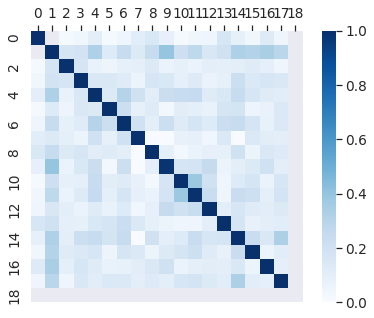

In [19]:
# Correlation matrix for responses to questions
cramersMatrix = compute_cramers_v_matrix(df_questions)
plot_cramers_v_matrix(cramersMatrix)

From a quick glance, it doesn't seem that any responses are highly correlated with any other responses... Note however that there is not any implication of significance here (need p-value).

In [20]:
# Correlation between political faction and economic faction
v = cramers_v(df_results['politics'], df_results['economics'], verbose=True, save=True)
print(f"\nCorrelation: {v:.3f}")

economics           Cryptopunk  Degen  Earner  NPC  Techtrepreneur
politics                                                          
Crypto-ancap              1.83   0.46    1.15 1.38           14.45
Crypto-leftist            0.69   0.00    1.15 1.83            7.34
Crypto-libertarian        1.38   1.15    4.59 6.42           28.21
DAOist                    1.15   0.23    0.92 2.98           12.16
True neutral              0.69   0.23    1.38 1.15            7.11

Correlation: 0.090


In [21]:
v = cramers_v(df_results['politics'], df_results['governance'], verbose=True, save=True)
print(f"\nCorrelation: {v:.3f}")

governance          Gavinist  Noob  Szabian  Walchian  Zamfirist
politics                                                        
Crypto-ancap            4.59  0.23    10.09      0.69       3.67
Crypto-leftist          2.98  0.00     0.69      2.75       4.59
Crypto-libertarian     17.89  0.69     7.11      2.98      13.07
DAOist                  7.11  0.00     1.83      2.52       5.96
True neutral            3.21  0.69     0.92      0.69       5.05

Correlation: 0.238


In [22]:
v = cramers_v(df_results['economics'], df_results['governance'], verbose=True, save=True)
print(f"\nCorrelation: {v:.3f}")

governance      Gavinist  Noob  Szabian  Walchian  Zamfirist
economics                                                   
Cryptopunk          1.61  0.00     2.06      0.46       1.61
Degen               1.61  0.00     0.23      0.00       0.23
Earner              3.67  0.23     2.06      0.92       2.29
NPC                 5.28  1.15     2.06      1.61       3.67
Techtrepreneur     23.62  0.23    14.22      6.65      24.54

Correlation: 0.142


For politics-economics and economics-governance, these values are also quite small (0 to 1 scale). **This indicates that these pairs of labels may suitably characterize two independent "axes" of belief.**

On inspection of the politics-governance cross-tabulation, **the proportion of crypto-ancap who were Szabians (or vice versa) was higher than for the other faction combinations**. This makes sense given the aversion to centralized governance inherent in both of these definitions.

## Ethereum v. Bitcoin
Are there any differences in responses between people affiliated with these ecosystems?

In [23]:
# Select respondents who included an affiliation with Ethereum or Bitcoin (not mutually exclusive)
optCol = n2qDict[19]
df_tmp = df_questions[pd.notnull(df_questions[optCol])]
df_eth = df_tmp.loc[df_tmp[optCol].apply(lambda x: 'Ethereum' in x)].drop(columns=[optCol])
df_btc = df_tmp.loc[df_tmp[optCol].apply(lambda x: 'Bitcoin' in x)].drop(columns=[optCol])
print("Number of Ethereum affiliates: ", len(df_eth.index))
print("Number of Bitcoin affiliates:  ", len(df_btc.index))

Number of Ethereum affiliates:  323
Number of Bitcoin affiliates:   91


### Most common responses to each question, for each affiliation

In [24]:
df_eth.rename(columns=q2nDict).mode()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,There is no one best blockchain.,Ethereum,Crypto is mainly a political philosophy and/or...,My goal in crypto is to create social change a...,Most or all cryptogovernance should be on-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto can do some go...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Most crypto teams make a fair and reasonable a...,The economic system in crypto is generally fai...,Most people who want to get ahead in crypto ca...,Work hand-in-hand with regulators to identify ...,Crypto has a gender problem.,A wide variety of on- and off-chain stakeholde...,the tech,Liberal or left-wing


In [25]:
df_btc.rename(columns=q2nDict).mode()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,There is no one best blockchain.,Ethereum,Crypto is mainly a political philosophy and/or...,My goal in crypto is to create social change a...,Most or all cryptogovernance should be on-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto will almost al...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Most crypto teams make a fair and reasonable a...,The economic system in crypto is generally fai...,Most people who want to get ahead in crypto ca...,"Keep on doing what we’re doing, legal or not.",Crypto does not have a gender problem.,A wide variety of on- and off-chain stakeholde...,the tech,Neither


Differences between these groups are in questions **7 (government regulation)**, **14 (government regulation)**, **15 (gender)**, and **18 (political affiliation)**.

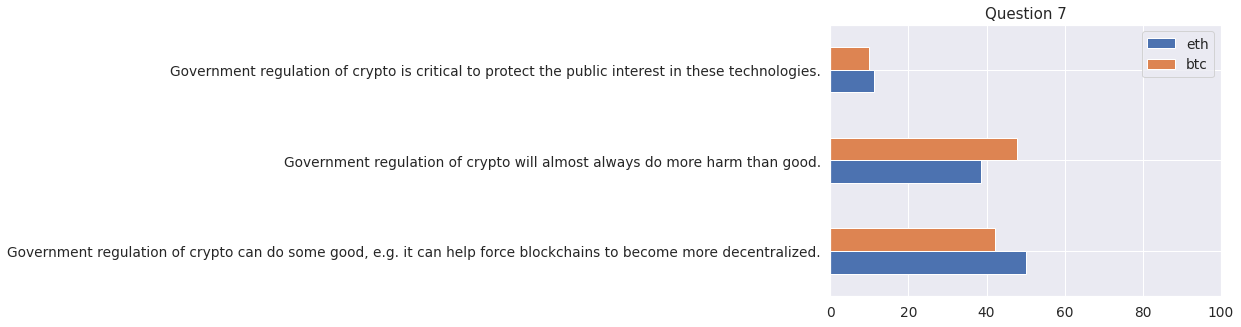

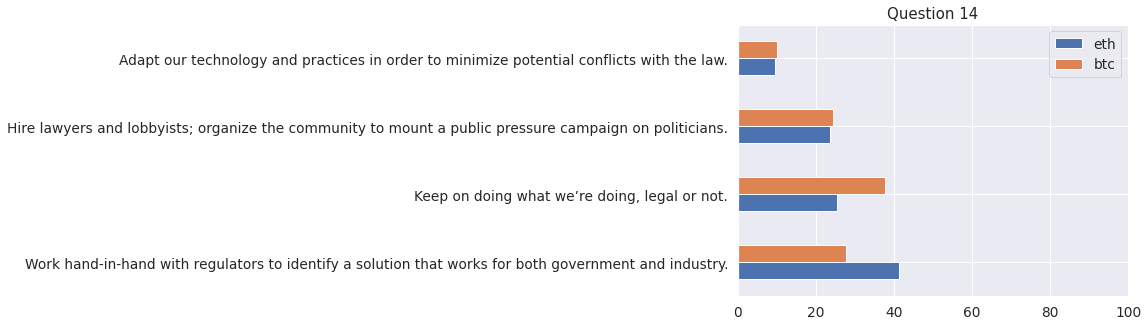

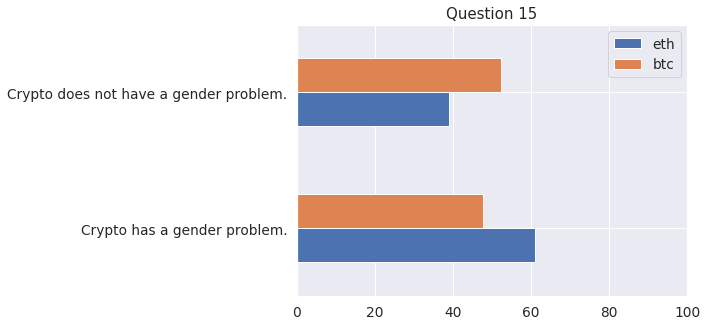

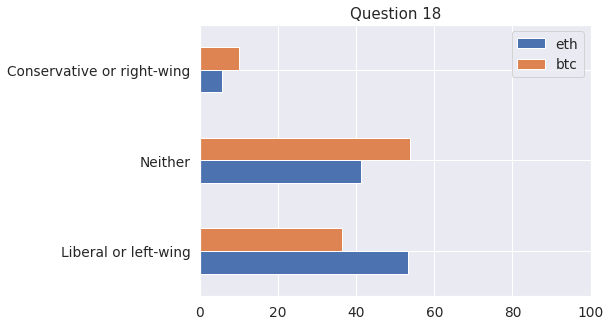

In [26]:
# Plot these differences in responses
for val in [7, 14, 15, 18]:
    df_tmp = pd.DataFrame()
    for ecosys, df in {'eth': df_eth, 'btc': df_btc}.items():
        df_tmp[ecosys] = df[n2qDict[val]].value_counts(normalize=True)*100    

    ax = df_tmp.plot.barh(title=f"Question {val}", xlim=(0,100))

    fname = f"{savedir}/crytopolitics_btc-v-eth_Q{val}"
    plt.savefig(f"{fname}.png", **kwargs_png)
    plt.savefig(f"{fname}.svg", **kwargs_svg)

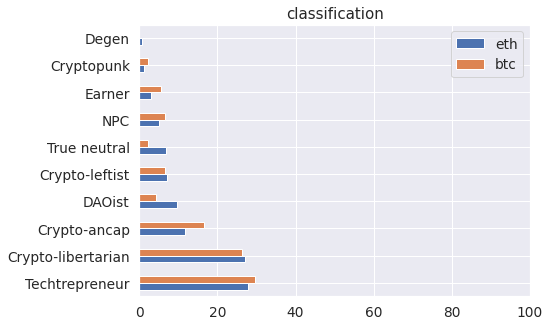

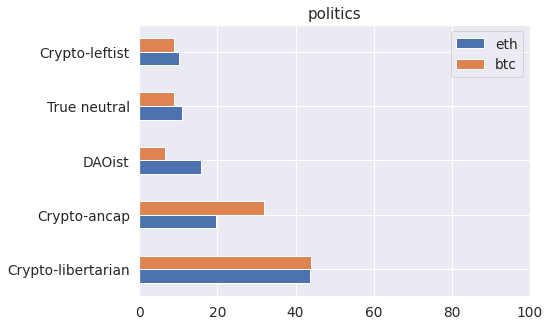

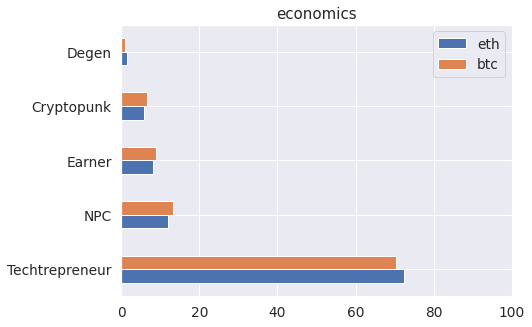

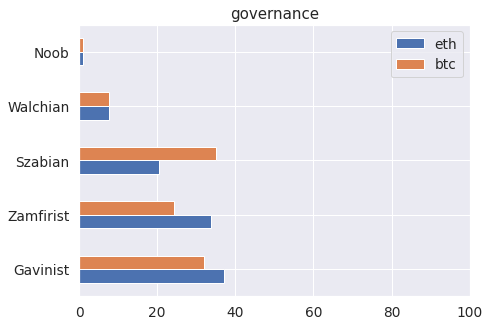

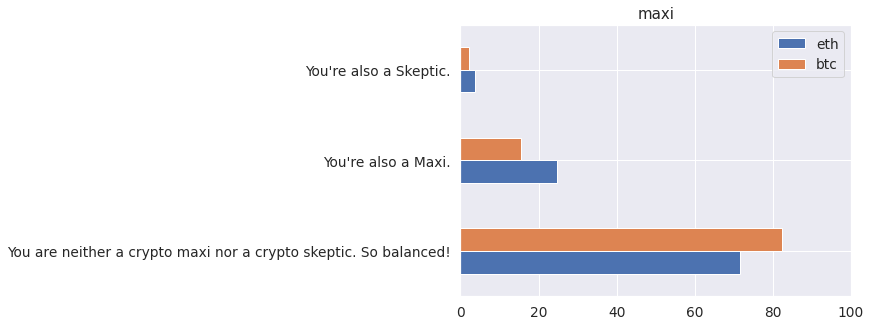

In [27]:
# Plot differences in assigned factions
for col in cols_results:
    df_tmp = pd.DataFrame()
    for ecosys, df in {'eth': df_eth, 'btc': df_btc}.items():
        df_r = df_results[df_results.index.isin(df.index)]
        df_tmp[ecosys] = df_r[col].value_counts(normalize=True)*100    

    ax = df_tmp.plot.barh(title=col, xlim=(0,100))
    
    fname = f"{savedir}/crytopolitics_btc-v-eth_{col}"
    plt.savefig(f"{fname}.png", **kwargs_png)
    plt.savefig(f"{fname}.svg", **kwargs_svg)

## Clustering
Crypto sentiment on axes: can we describe clusters in a meaningful way?

## Hierarchical clustering
Agglomerative clustering 

#### Preprocessing
- Drop rows with any emtpy vals; drop questions relating to specific ecosystems
- Create two versions of the data:
    - All questions one-hot encoded; shape=(391,49)
    - All but four categorical questions mapped to ordinal values on -1 to 1 scale; shape=(391,29)

In [28]:
# Preprocessing
df_tmp = df_questions.drop(columns=[n2qDict[2], n2qDict[19]])
df_to_cluster = df_tmp[~df_tmp.isnull().any(axis=1)]

In [29]:
# Import ordinal mapping from file
df_map = pd.read_csv('cryptopolitics_quiz_cluster_mapping.csv')
gb_map = df_map.groupby('Question')

# Convert to dictionary
mappingDict = {}
for key, value in gb_map:
    
    df_q = gb_map.get_group(key)
    questionDict = {}
    for i, row in gb_map.get_group(key).iterrows():
        questionDict[row['Answer']] = row['Mapping']
    
    mappingDict[key] = questionDict

# Rename dictionary items for ease of working with it
mappingDict = {n2qDict[k]: v for (k, v) in mappingDict.items()}

In [30]:
# Get mapped version of full response DataFrame
df_mapped = df_to_cluster.copy()
for col in df_mapped.columns:
    df_mapped[col] = df_mapped[col].map(mappingDict[col])

In [31]:
# Encode categorical as one-hot
v = DictVectorizer(sparse=False)
cols_categorical = [n2qDict[x] for x in [4,9,16,17]]
X_categorical = v.fit_transform(df_mapped[cols_categorical].to_dict(orient='records'))
df_categorical = pd.DataFrame(X_categorical, columns=v.get_feature_names_out())

# Merge with ordinal to create mixed ordinal-categorical data
df_ordinal = df_mapped.drop(columns=cols_categorical)
df_mixed = pd.concat([df_ordinal.reset_index(drop=True), df_categorical], axis=1, ignore_index=True)
X_mixed = df_mixed.to_numpy()
df_mixed.shape

(391, 29)

In [32]:
# Encode all as one-hot (only categorical data)
v = DictVectorizer(sparse=False)
X_allCat = v.fit_transform(df_to_cluster.to_dict(orient='records'))
df_allCat = pd.DataFrame(X_allCat, columns=v.get_feature_names_out())
df_allCat.shape

(391, 49)

#### Dimensionality reduction/group questions by responses
- PCA: linearity assumption
- Isomap: nonlinearity allowed

In [33]:
def scatter_plot_combos(X, N, colors=None, title=''):
    """Given X with shape (n_samples, n_dimensions) where n_dimensions may be >2,
    plot each combination of dimensions as a 2D scatter plot, with colors optionally specified"""
    
    kwargs = {}
    if colors is not None:
        kwargs['color'] = colors
    if title != '':
        title = title + ': '
    
    for combo in list(combinations(list(range(N)), 2)):
        plt.figure()
        plt.scatter(X[:,combo[0]], X[:,combo[1]], **kwargs)
        plt.xlabel(combo[0])
        plt.ylabel(combo[1])
        plt.title(f"{title}n_components = {N} {combo}")

In [34]:
def compute_and_plot_pca(X, N):
    """Compute and plot PCA transformation of data"""
    
    # Transform
    pca = PCA(n_components=N)
    X_transformed = pca.fit_transform(X)
    
    # Display some results
    for component in pca.components_:
        print("[", ', '.join([f"{x:.1f}" for x in component]), "]")
    print(f"Variance explained: {sum(pca.explained_variance_ratio_)*100:.1f}%")

    # Plot
    scatter_plot_combos(X_transformed, N, title='PCA')

    return X_transformed, pca

In [35]:
## Isomap
def compute_and_plot_isomap(X, N, metric='cosine'):
    """Compute and plot isomap transformation of data
    
    Choice of distance metric is very important!"""
    
    # Transform
    iso = Isomap(n_components=N, metric=metric) #cosine, cityblock, hamming, dice
    X_transformed = iso.fit_transform(X)
    
    # Display some results
    for component in iso.kernel_pca_.eigenvectors_[:N]:
        print("[", ', '.join([f"{x:.2f}" for x in component]), "]")

    # Plot
    scatter_plot_combos(X_transformed, N, title=f'Isomap ({metric})')

    return X_transformed, iso

[ -0.0, 0.2, -0.2, -0.1, -0.2, 0.2, -0.1, -0.5, -0.6, -0.4, 0.1, 0.1, -0.2, 0.0, 0.1, -0.1, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0 ]
[ -0.0, 0.8, -0.0, -0.0, -0.1, 0.2, 0.0, 0.1, 0.2, 0.1, 0.4, -0.1, 0.1, 0.0, -0.1, 0.1, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1, 0.1, -0.0, -0.0, 0.1, 0.0 ]
[ -0.0, -0.5, -0.2, -0.1, -0.4, 0.3, 0.1, 0.2, 0.1, 0.0, 0.6, 0.1, -0.1, 0.0, 0.1, -0.1, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.1, -0.0, 0.0, -0.0, 0.0, -0.0 ]
Variance explained: 38.9%


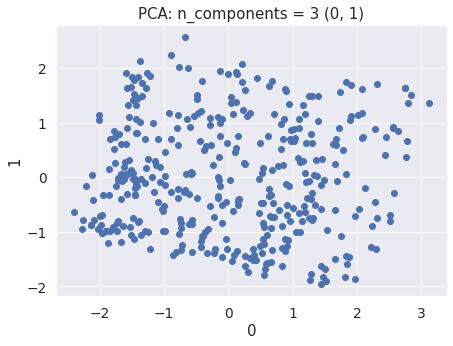

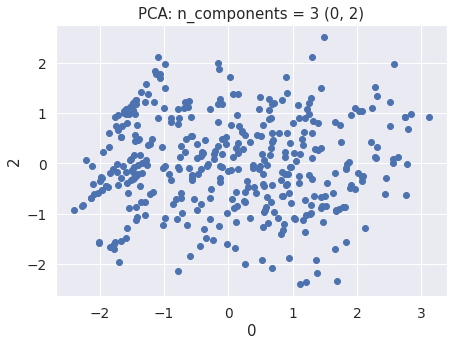

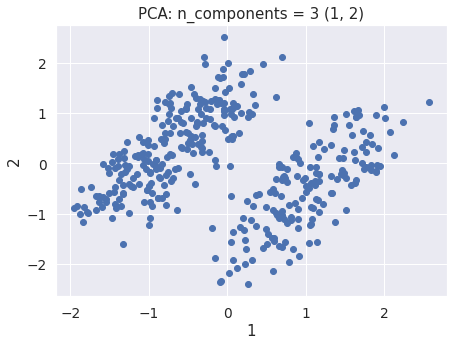

In [36]:
# PCA on mostly-ordinal data
X_pca_mixed_3 = compute_and_plot_pca(X_mixed, 3)

[ 0.03, -0.06, 0.08 ]
[ 0.06, 0.01, -0.03 ]
[ 0.02, 0.01, -0.00 ]


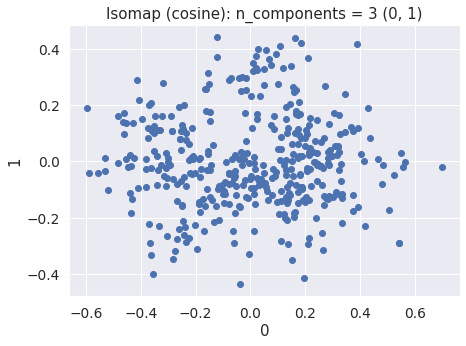

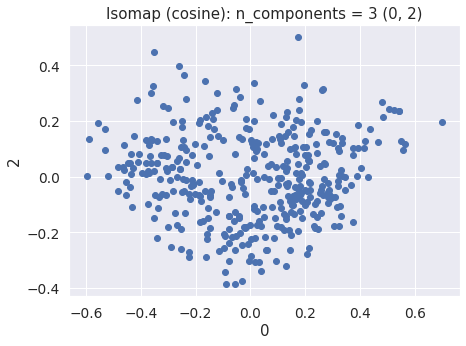

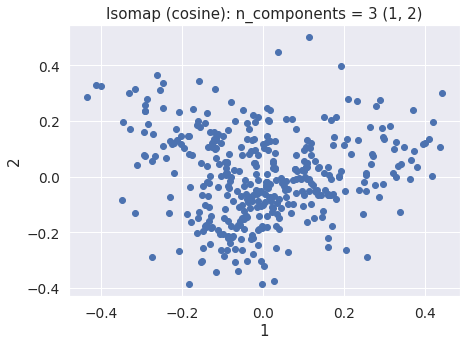

In [37]:
# Isomap on one-hot encoded data
X_iso_allCat_3 = compute_and_plot_isomap(X_allCat, 3)

[ 0.02, 0.03, 0.02 ]
[ 0.04, -0.02, -0.08 ]
[ 0.02, -0.02, 0.06 ]


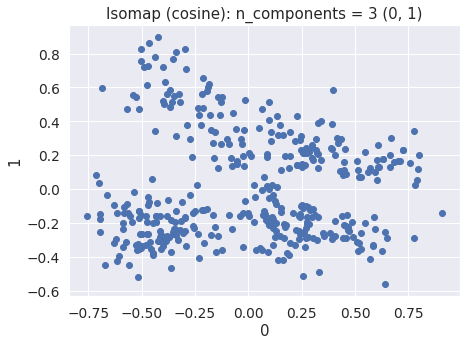

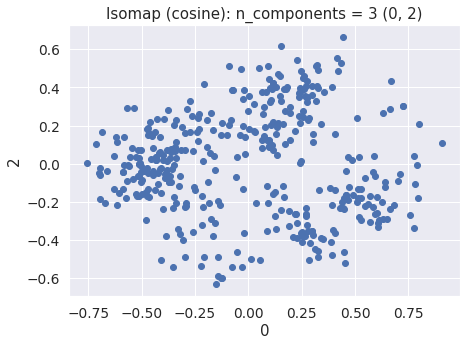

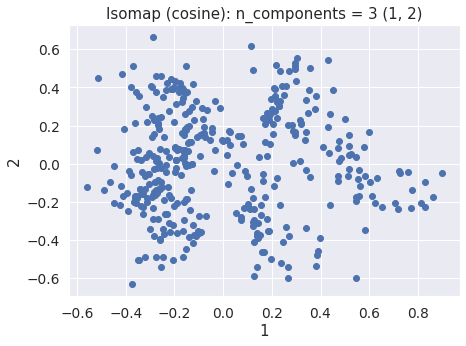

In [38]:
# Isomap on mostly-ordinal data
X_iso_mixed_3 = compute_and_plot_isomap(X_mixed, 3)

#### Clustering/group responses by questions
- Kmeans: imposes equal cluster sizes - don't want that!
- Agglomerative clustering: starts with individual responses and agglomerates responses hierarchically by "distance"

In [39]:
def plot_dendrogram(model, **kwargs):
    """Create linkage matrix and plot the dendrogram
    
    Based on scikit-learn example:
    https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
    """

    # Create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.xlabel("Number of points in node (or index of point if no parenthesis)")

In [40]:
colors = np.array(["#ff0000",
                  "#00ff00",
                  "#0000ff",
                  "#ffff00",
                  "#ff00ff",
                  "#00ffff",
                  "#ff8800",
                  "#ff0088",
                  "#88ff00",
                  "#00ff88",
                  "#8800ff",
                  "#0088ff",
                  "#ff8888",
                  "#88ff88",
                  "#8888ff",
                  "#880000",
                  "#008800",
                  "#000088",
                  "#888800",
                  "#880088",
                  "#008888",
                  "#884400",
                  "#880044",
                  "#448800",
                  "#008844",
                  "#440088",
                  "#004488",
                  "#884444",
                  "#448844",
                  "#444488",
                  ])

In [41]:
def run_agglomerative_clustering(X, nClusters, kwargs={}):
    """Run agglomerative clustering"""
    
    ac = AgglomerativeClustering(compute_distances=True,
                                 n_clusters=nClusters,
                                 **kwargs)
    
    ac = ac.fit(X)
    y_predicted = ac.labels_.astype(int)

    plt.figure()
    plot_dendrogram(ac, truncate_mode="level", p=3)

    scatter_plot_combos(X, X.shape[1], colors=colors[y_predicted])

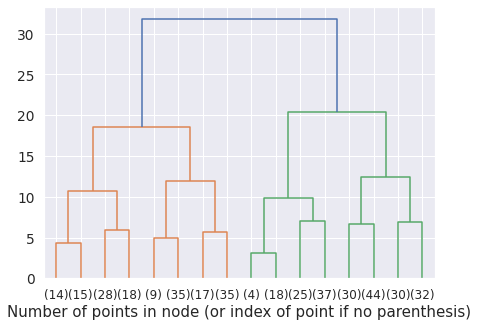

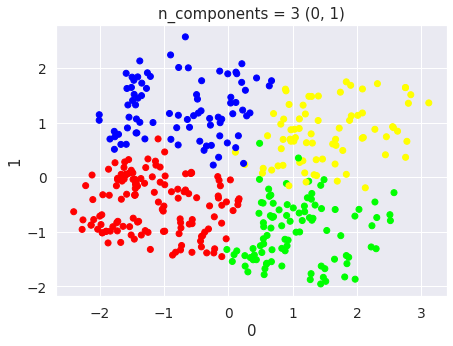

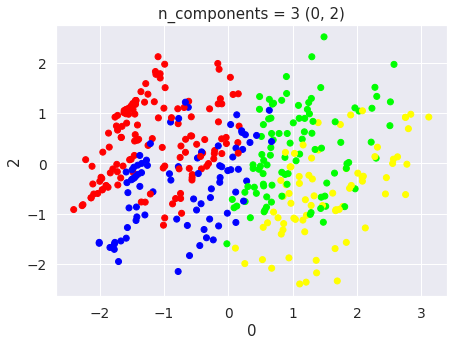

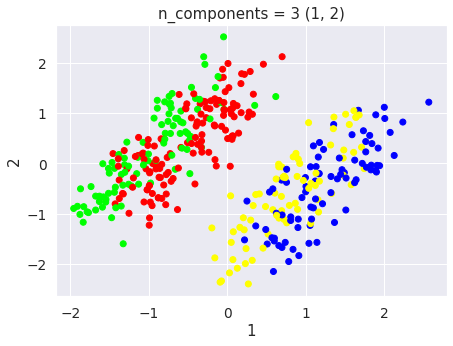

In [42]:
run_agglomerative_clustering(X_pca_mixed_3[0], 4)

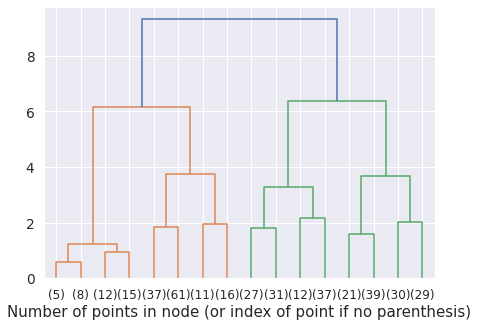

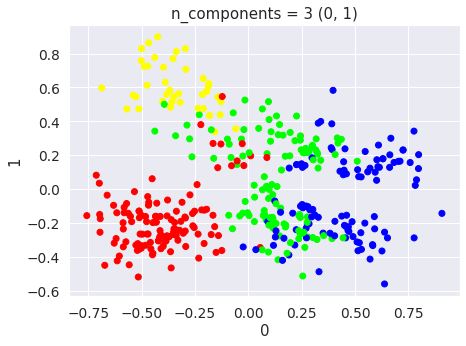

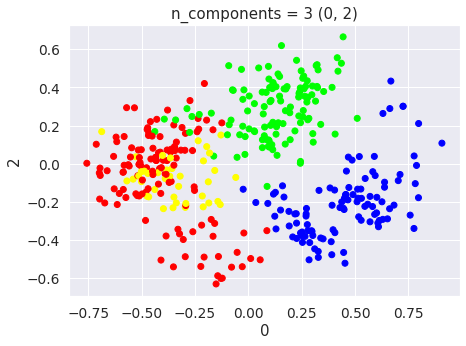

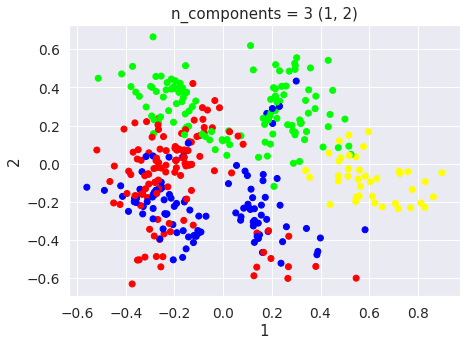

In [43]:
run_agglomerative_clustering(X_iso_mixed_3[0], 4)

## K-means clustering
Since this imposes even cluster sizes, this is probably not a good fit for this data

Two options for this:
1. Treat the data as purely categorical and use [kmodes](https://pypi.org/project/kmodes/) clustering
2. Assign a numerical value to each response (e.g., binary or Likert-scale-like) where possible (though subjective); leave the rest categorical, then use kprototypes clustering

In [44]:
def k_clustering_sweep(responseMatrix, kMax=20, method=KModes, kwargs={}):
    """Find clusters using method (KModes or KPrototype)
    Sweep from k=1 to k=kMax and plot resulting cost to evaluate which k may be most useful"""
    
    costMatrix = []
    kValues = list(np.arange(1, kMax+1))
    clusterCentroids = {}
    for k in range(1, kMax+1):
        # Fit and predict clusters, then save centroids and cost
        clusters = method(n_clusters=k, n_init=20)
        clusters.fit_predict(responseMatrix, **kwargs)
        costMatrix.append(clusters.cost_)
        clusterCentroids[k] = clusters.cluster_centroids_
    
    # Plot result of sweep
    plt.plot(kValues, np.divide(costMatrix, max(costMatrix)))
    plt.xlabel("k")
    plt.ylabel("cost")
    
    return clusterCentroids

### Option 1: categorical only

In [45]:
# Drop spares columns and columns with lists as responses, then drop columns with ANY null values
df_tmp = df_questions.drop(df_questions.columns[[1,18]], axis=1)
df_tmp = df_tmp[~df_tmp.isnull().any(axis=1)]

responseMatrix = df_tmp.to_numpy()
print(responseMatrix.shape)

(391, 17)


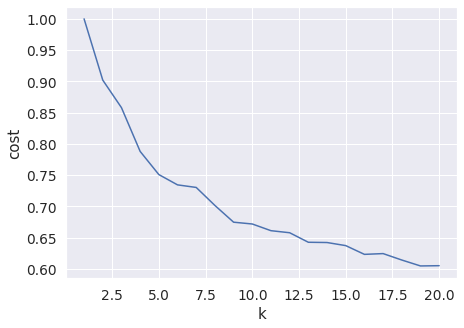

In [46]:
clusterCentroids = k_clustering_sweep(responseMatrix)

Let's see what the results look like for **6 clusters**:

In [47]:
df_clusters = pd.DataFrame(clusterCentroids[6])
df_clusters

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,There is no one best blockchain.,Crypto is mainly a political philosophy and/or...,My goal in crypto is to create social change a...,Most or all cryptogovernance should be on-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto can do some go...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Most crypto teams make a fair and reasonable a...,The economic system in crypto is generally fai...,Most people who want to get ahead in crypto ca...,Work hand-in-hand with regulators to identify ...,Crypto has a gender problem.,A wide variety of on- and off-chain stakeholde...,the tech,Liberal or left-wing
1,There is no one best blockchain.,Crypto is mainly an economic technology.,My goal in crypto is to create social change a...,Most or all cryptogovernance should be on-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto can do some go...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Crypto teams make too much profit.,The economic system in crypto unfairly favors ...,Most people who want to get ahead in crypto ca...,Work hand-in-hand with regulators to identify ...,Crypto does not have a gender problem.,"The token holders and/or node operators, i.e. ...",the tech,Neither
2,There is no one best blockchain.,Crypto is mainly a political philosophy and/or...,My goal in crypto is to create social change a...,Most or all cryptogovernance should be on-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto will almost al...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Crypto teams make too much profit.,The economic system in crypto unfairly favors ...,Hard work and determination are no guarantee o...,"Keep on doing what we’re doing, legal or not.",Crypto does not have a gender problem.,A wide variety of on- and off-chain stakeholde...,the tech,Neither
3,There is no one best blockchain.,Crypto is mainly an economic technology.,My goal in crypto is to create social change a...,Crypto does not need (human) governance; let t...,Privacy is the most important feature of block...,Government regulation of crypto will almost al...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Most crypto teams make a fair and reasonable a...,The economic system in crypto is generally fai...,Most people who want to get ahead in crypto ca...,"Keep on doing what we’re doing, legal or not.",Crypto does not have a gender problem.,"The token holders and/or node operators, i.e. ...",the tech,Neither
4,There is no one best blockchain.,Crypto is mainly an economic technology.,My goal in crypto is to create social change a...,Most or all cryptogovernance should be on-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto will almost al...,Having a central bank run a cryptocurrency is ...,Help people around the world earn a living.,Blockchain and DeFi are beneficial technologie...,Most crypto teams make a fair and reasonable a...,The economic system in crypto unfairly favors ...,Most people who want to get ahead in crypto ca...,Adapt our technology and practices in order to...,Crypto does not have a gender problem.,"The token holders and/or node operators, i.e. ...",the jobs,Neither
5,There is no one best blockchain.,Crypto is mainly an economic technology.,My goal in crypto is to create social change a...,Most or all cryptogovernance should be off-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto can do some go...,Having a central bank run a c

In [48]:
# Map to integer, just for plotting purposes
df_to_plot = df_clusters.copy()
for col in df_to_plot.columns:
    d = {val: i for (i, val) in enumerate(df_to_plot[col].unique())}
    df_to_plot[col] = df_to_plot[col].map(d)

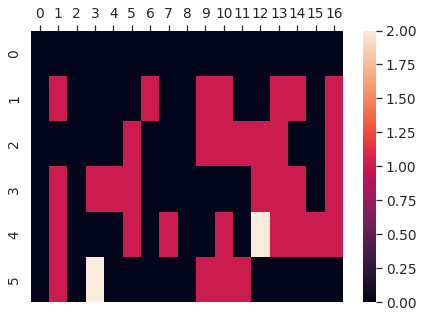

In [49]:
# Plot where centroid value for each question differs between clusters
# If a column is all black, all clusters had the same response.
# If more than one color appears in a column, that number of different responses appeared across clusters.
plt.figure()
fig = sns.heatmap(df_to_plot.astype('float'), cmap=sns.color_palette("rocket", as_cmap=True))
fig.xaxis.set_ticks_position("top")

### Option 2: mixed categorical and ordinal

In [50]:
# Import ordinal mapping from file
df_map = pd.read_csv('cryptopolitics_quiz_cluster_mapping.csv')
gb_map = df_map.groupby('Question')

# Convert to dictionary
mappingDict = {}
for key, value in gb_map:
    
    df_q = gb_map.get_group(key)
    questionDict = {}
    for i, row in gb_map.get_group(key).iterrows():
        questionDict[row['Answer']] = row['Mapping']
    
    mappingDict[key] = questionDict

# Rename dictionary items for ease of working with it
mappingDict = {n2qDict[k]: v for (k, v) in mappingDict.items()}

In [51]:
# Get mapped version of full response DataFrame
df_mapped = df_questions.drop(df_questions.columns[[1,18]], axis=1).copy()
for col in df_mapped.columns:
    df_mapped[col] = df_mapped[col].map(mappingDict[col])

# Drop rows with any null values
df_tmp = df_mapped[~df_mapped.isnull().any(axis=1)]
responseMatrix_mapped = df_tmp.to_numpy()

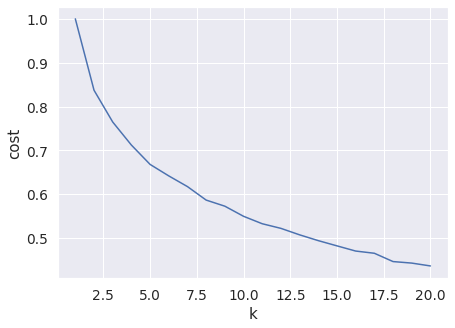

In [52]:
clusterCentroids_mapped = k_clustering_sweep(responseMatrix_mapped,
                                             method=KPrototypes,
                                             kwargs={'categorical': [2,7,14,15]})

It's not obvious to me that there's a particularly good number of clusters to stop at. But, to compare with above, let's see what the results look like for **6 clusters**:

In [53]:
df_cluster_mapped = pd.DataFrame(clusterCentroids_mapped[6])

In [54]:
# For context, get mapping value ranges for each question involved
# Unfortunately KPrototypes shuffles around column orders a bit, which is annoying...
mappingRange = {q2nDict[k]: (min(v.values()), max(v.values())) for (k, v) in mappingDict.items()}
mappingRangeList = []
for key in [1,3,5,6,7,8,10,11,12,13,14,15,18]:
    x = mappingRange[key]
    mappingRangeList.append((float(x[0]), float(x[1])))

In [55]:
# Some pretty printing to keep track of what's happening...
def format_if_float(x):
    try:
        x = float(x)
    except ValueError:
        pass
    
    if isinstance(x, float):
        return f"{x:.2f}"
    else:
        return x
    
print("Range of mapped values for each question:")
pprint.pprint({i: val for (i, val) in enumerate(mappingRangeList)})
print("\nCoordinate of centroid for each question:")
print('\t'.join([str(x) for x in np.arange(1,len(df_cluster_mapped.columns)+1)]))
for i, row in df_cluster_mapped.iterrows():
    print('\t'.join([format_if_float(x) for (j, x) in row.iteritems()]))

Range of mapped values for each question:
{0: (0.0, 1.0),
 1: (-1.0, 1.0),
 2: (-0.5, 1.0),
 3: (0.0, 1.0),
 4: (-1.0, 1.0),
 5: (-1.0, 1.0),
 6: (-1.0, 1.0),
 7: (-1.0, 1.0),
 8: (-1.0, 1.0),
 9: (-1.0, 1.0),
 10: (-0.5, 1.0),
 11: (0.0, 1.0),
 12: (-1.0, 1.0)}

Coordinate of centroid for each question:
1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17
0.27	1.00	0.38	0.24	0.38	-0.55	0.97	0.61	0.55	1.00	0.15	0.38	-0.21	C	C	B	C
0.22	1.00	-0.02	0.12	0.03	-0.23	0.70	-0.97	-0.93	-0.13	0.30	0.68	-0.63	C	C	B	C
0.24	-1.00	0.38	0.26	0.36	-0.72	0.96	0.67	1.00	1.00	0.07	0.49	-0.35	C	C	B	C
0.27	-1.00	0.15	0.19	0.31	-0.55	0.94	-0.23	-1.00	1.00	-0.04	0.69	-0.53	C	C	B	C
0.23	-0.29	0.26	0.33	0.25	-0.62	0.92	0.12	1.00	-1.00	0.06	0.58	-0.54	C	C	B	C
0.17	-0.62	0.05	0.21	0.09	-0.59	0.66	0.03	-1.00	-1.00	0.03	0.81	-0.67	C	C	B	C


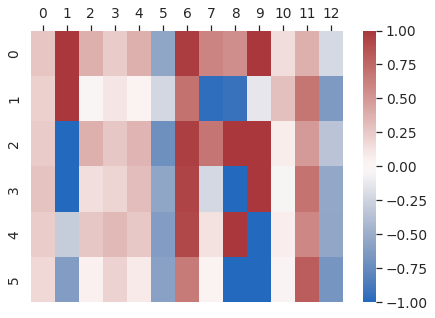

In [56]:
# Plot centroid (roughly, "sentiment") value for each mapped question
# The diverging color palette was chosen so that for values where answers were mapped from -1 to 1
# (indicating opposite opinions), the contrast is clear between red and blue, while for questions
# which were mapped from 0 to 1, the color ranges from neutral white to red.
plt.figure()
fig = sns.heatmap(df_cluster_mapped.iloc[:,:13].astype('float'),
                  cmap=sns.color_palette("vlag", as_cmap=True),
                  vmin=-1, vmax=1)
fig.xaxis.set_ticks_position("top")